<a href="https://colab.research.google.com/github/2303A52328/Explainable_AI/blob/main/Exp_ai_ass_6_2428.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Shape: (50000, 11)

Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   patient_id                 50000 non-null  int64  
 1   age                        50000 non-null  int64  
 2   gender                     50000 non-null  object 
 3   pack_years                 50000 non-null  float64
 4   radon_exposure             50000 non-null  object 
 5   asbestos_exposure          50000 non-null  object 
 6   secondhand_smoke_exposure  50000 non-null  object 
 7   copd_diagnosis             50000 non-null  object 
 8   alcohol_consumption        33338 non-null  object 
 9   family_history             50000 non-null  object 
 10  lung_cancer                50000 non-null  object 
dtypes: float64(1), int64(2), object(8)
memory usage: 4.2+ MB
None

Summary statistics:
           patient_id           age    pack_year

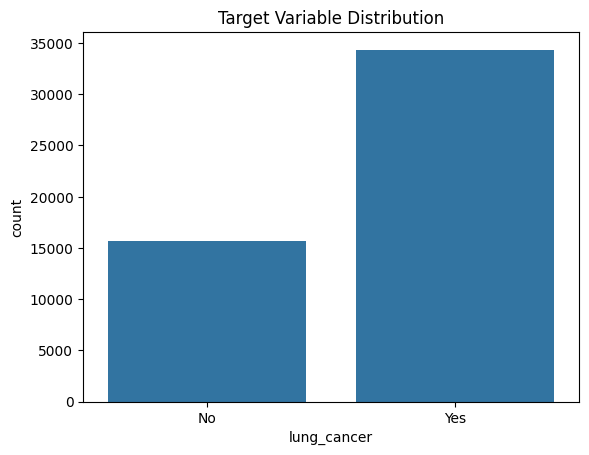

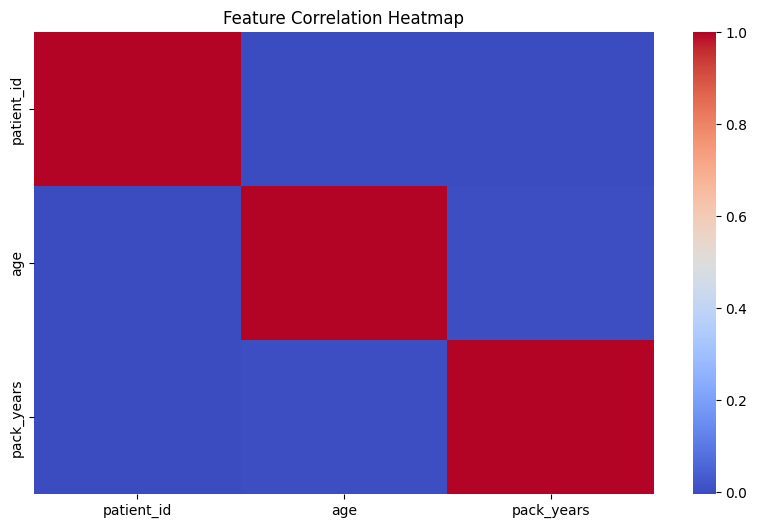

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
df = pd.read_csv("/content/lung_cancer_dataset.csv")

# Dataset overview
print("Shape:", df.shape)
print("\nInfo:\n")
print(df.info())
print("\nSummary statistics:\n", df.describe())

# Missing values
print("\nMissing Values:\n", df.isnull().sum())

# Distribution of target (assuming target column is 'LUNG_CANCER' or similar)
target_col = "lung_cancer"  # change if your column is named differently
sns.countplot(x=target_col, data=df)
plt.title("Target Variable Distribution")
plt.show()

# Correlation heatmap (only numerical features)
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(numeric_only=True), cmap="coolwarm", annot=False)
plt.title("Feature Correlation Heatmap")
plt.show()

In [7]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

# Encode categorical variables
for col in df.select_dtypes(include=['object']).columns:
    df[col] = LabelEncoder().fit_transform(df[col].astype(str))

# Handle missing values
df = df.fillna(df.median())

# Features & target
X = df.drop(target_col, axis=1)
y = df[target_col]

# Scale features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Handle class imbalance with SMOTE
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, stratify=y_res, random_state=42)

print("Train shape:", X_train.shape, " Test shape:", X_test.shape)


Train shape: (54982, 10)  Test shape: (13746, 10)


In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

ml_models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "SVM": SVC(probability=True),
    "KNN": KNeighborsClassifier(),
    "XGBoost": xgb.XGBClassifier(use_label_encoder=False, eval_metric="logloss")
}

results = []
for name, model in ml_models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, model.predict_proba(X_test)[:,1])
    results.append([name, acc, prec, rec, f1, auc])

results_df = pd.DataFrame(results, columns=["Model","Accuracy","Precision","Recall","F1","ROC-AUC"])
print(results_df)


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:30:12] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


                 Model  Accuracy  Precision    Recall        F1   ROC-AUC
0  Logistic Regression  0.670741   0.670443  0.671614  0.671028  0.738724
1        Decision Tree  0.684272   0.691054  0.666521  0.678566  0.684272
2        Random Forest  0.768442   0.790643  0.730249  0.759247  0.853262
3                  SVM  0.694384   0.710925  0.655172  0.681911  0.760543
4                  KNN  0.724356   0.767801  0.643242  0.700024  0.791926
5              XGBoost  0.735559   0.732816  0.741452  0.737109  0.825023


In [9]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Flatten, LSTM, MaxPooling1D, Dropout

# 1. Multi-Layer Perceptron (MLP)
mlp = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])
mlp.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
mlp.fit(X_train, y_train, epochs=20, batch_size=16, validation_split=0.2, verbose=0)

# 2. CNN (1D)
cnn = Sequential([
    tf.keras.layers.Reshape((X_train.shape[1],1), input_shape=(X_train.shape[1],)),
    Conv1D(32, 3, activation='relu'),
    Conv1D(64, 3, activation='relu'),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])
cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
cnn.fit(X_train, y_train, epochs=20, batch_size=16, validation_split=0.2, verbose=0)

# 3. RNN with LSTM
lstm = Sequential([
    tf.keras.layers.Reshape((X_train.shape[1],1), input_shape=(X_train.shape[1],)),
    LSTM(64),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])
lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
lstm.fit(X_train, y_train, epochs=20, batch_size=16, validation_split=0.2, verbose=0)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [10]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=11e95dca7852bc036d16ab06ed789fdf00fa74f8ad2becb1091a35f0b584ef92
  Stored in directory: /root/.cache/pip/wheels/e7/5d/0e/4b4fff9a47468fed5633211fb3b76d1db43fe806a17fb7486a
Successfully built lime
